In [10]:
import os

from typing import Type, Dict, List, Tuple, Optional

import matplotlib.pyplot as plt
import torch
import pyro
import seaborn as sns
import torch
import contextlib

from pyro.infer.autoguide import AutoDiagonalNormal

from torch.utils.data import DataLoader

import pyro

from cities.modeling.simple_linear import SimpleLinear
from cities.modeling.add_categorical_interactions import AddCategoricalInteractions
from cities.modeling.add_causal_layer import AddCausalLayer 
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data
from pyro.infer import Predictive

import contextlib


smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=len(zoning_dataset_read), shuffle=True
)

data = next(iter(zoning_loader))

print(data['continuous'].keys())

print(data['categorical'].keys())
print(data['continuous'].keys())


minimal_kwargs = {  
    "categorical": ["past_reform"],
    "continuous": {"parcel_area"},
    "outcome": "housing_units",
}

minimal_subset = select_from_data(data, minimal_kwargs)

# will want to add zone_id -> parcel_area and zone_id -> housing_units
expanded_kwargs = {  
    "categorical": ["zone_id", "past_reform"],
    "continuous": {"parcel_area"},
    "outcome": "housing_units",
}

expanded_subset = select_from_data(data, expanded_kwargs)

print(expanded_subset['outcome'].shape)

dict_keys(['parcel_area', 'car_parking', 'housing_units', 'parcel_area_original', 'car_parking_original', 'housing_units_original'])
dict_keys(['parcel_id', 'neighborhood_id', 'ward_id', 'zone_id', 'limit_id', 'past_reform', 'year', 'month'])
dict_keys(['parcel_area', 'car_parking', 'housing_units', 'parcel_area_original', 'car_parking_original', 'housing_units_original'])
torch.Size([302])


In [3]:
base_model = SimpleLinear(**minimal_subset)

base_model(**minimal_subset)
print(minimal_subset['categorical'].keys())
print(minimal_subset['continuous'].keys())

dict_keys(['past_reform'])
dict_keys(['parcel_area'])


In [4]:
# minimal with non-trivial causal layer

with AddCausalLayer(base_model,
        model_kwargs = minimal_kwargs,
        dataset = data,
        causal_layer={"parcel_area": ["zone_id", "neighborhood_id", "car_parking_original"], "housing_units": ["zone_id", "car_parking_original"]}):
    with pyro.poutine.trace() as tr:
        base_model(**minimal_subset)


print(tr.trace.nodes.keys())


assert torch.allclose(tr.trace.nodes['parcel_area']['value'], data['continuous']['parcel_area'])
assert torch.allclose(tr.trace.nodes['outcome_observed']['value'], data['continuous']['housing_units'])





odict_keys(['data_1', 'weights_categorical_zone_id_parcel_area', 'weights_categorical_neighborhood_id_parcel_area', 'bias_continuous_parcel_area', 'weight_continuous_parcel_area', 'sigma_parcel_area', 'mean_outcome_prediction_parcel_area', 'parcel_area', 'weights_categorical_zone_id_housing_units', 'bias_continuous_housing_units', 'weight_continuous_housing_units', 'sigma_housing_units', 'mean_outcome_prediction_housing_units', 'housing_units', 'sigma', 'data', 'weights_categorical_past_reform', 'bias_continuous', 'weight_continuous', 'mean_outcome_prediction', 'outcome_observed'])


[iteration 0001] loss: 30457.9199
[iteration 0050] loss: 7370.5186
[iteration 0100] loss: 1725.8237
[iteration 0150] loss: 2009.1890
[iteration 0200] loss: 2488.7673
[iteration 0250] loss: 2901.8884
[iteration 0300] loss: 2492.9490
[iteration 0350] loss: 1902.8994
[iteration 0400] loss: 1907.0200
[iteration 0450] loss: 2234.3538
[iteration 0500] loss: 2003.7900


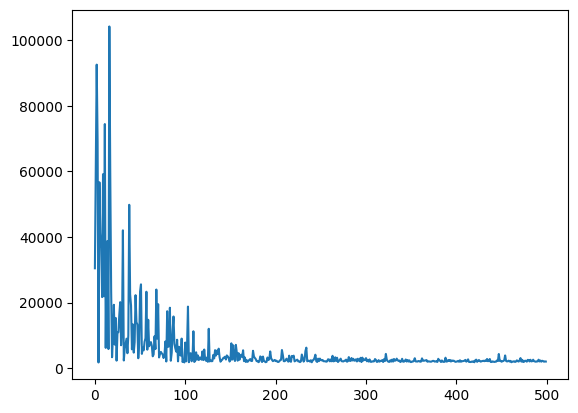

In [5]:
def new_model(**kwargs):
    with AddCausalLayer(base_model,
        model_kwargs = minimal_kwargs,
        dataset = data,
        causal_layer={"parcel_area": ["zone_id", "neighborhood_id", "car_parking_original"], "housing_units": ["zone_id", "car_parking_original"]}):
        with pyro.poutine.trace() as tr:
            base_model(**minimal_subset)


new_guide  = run_svi_inference(new_model, **minimal_subset)


In [6]:
predictive = Predictive(
    new_model, guide=new_guide, num_samples=num_samples, parallel=True
)

samples = predictive(**minimal_subset)

print(
samples.keys()
)

assert samples['weights_categorical_zone_id_parcel_area'].squeeze().shape  == (1000,4)


dict_keys(['weights_categorical_zone_id_parcel_area', 'weights_categorical_neighborhood_id_parcel_area', 'bias_continuous_parcel_area', 'weight_continuous_parcel_area', 'sigma_parcel_area', 'weights_categorical_zone_id_housing_units', 'bias_continuous_housing_units', 'weight_continuous_housing_units', 'sigma_housing_units', 'sigma', 'weights_categorical_past_reform', 'bias_continuous', 'weight_continuous', 'mean_outcome_prediction_parcel_area', 'parcel_area', 'mean_outcome_prediction_housing_units', 'housing_units', 'mean_outcome_prediction', 'outcome_observed'])


In [13]:
n = 600
part = n // 3
n_steps = 600

x_cat = torch.cat(
    [
        torch.zeros([part], dtype=torch.long),
        torch.ones([part], dtype=torch.long),
        2 * torch.ones([part], dtype=torch.long),
    ]
)
x_con = torch.cat([torch.ones(n//2), torch.ones(n//2) * 2]) + torch.randn(n) * 0.1 + 0.5 * x_cat 


y_mixed = x_cat * 2 + x_con * 2 + torch.randn(n) * 0.05


synthetic_minimal = {
    "categorical": {"x_cat": x_cat},
    "continuous": {"x_con": x_con, "y_mixed": y_mixed   },
}

synthetic_expanded = {
    "categorical": {"x_cat": x_cat},
    "continuous": {"x_con": x_con, "y_mixed": y_mixed },
}

minimal_kwargs_synthetic = {
    "categorical": {"x_cat"},
    "continuous": {"x_con"},
    "outcome": "y_mixed",
}

expanded_kwargs_synthetic = {
    "categorical": {"x_cat"},
    "continuous": {"x_con"},
    "outcome": "y_mixed",
}

[iteration 0001] loss: 3396.9260
[iteration 0050] loss: 1328.8409
[iteration 0100] loss: 886.0375
[iteration 0150] loss: 218.9109
[iteration 0200] loss: 201.5706
[iteration 0250] loss: 194.1872
[iteration 0300] loss: 260.9788
[iteration 0350] loss: 193.3844
[iteration 0400] loss: 200.3615
[iteration 0450] loss: 198.2525
[iteration 0500] loss: 209.5885


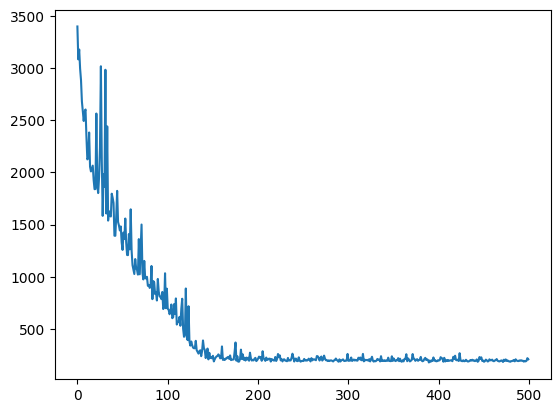

In [16]:
pyro.clear_param_store()

base_model_synthetic = SimpleLinear(**synthetic_minimal)


def new_model_synthetic(**kwargs):
    with AddCausalLayer(base_model,
        model_kwargs = minimal_kwargs_synthetic,
        dataset = synthetic_expanded,
        causal_layer={"x_con": ["x_cat"]}):
            base_model(**synthetic_minimal)

new_guide_synthetic  = run_svi_inference(new_model_synthetic, **synthetic_minimal, vi_family=AutoDiagonalNormal)
# note autodiagonalnormal fails, not clear why




In [17]:
predictive_synthetic = Predictive(
    new_model_synthetic, guide=new_guide_synthetic, num_samples=num_samples, parallel=True
)

samples_synthetic = predictive_synthetic(**synthetic_minimal)

print(
samples_synthetic.keys()
)

dict_keys(['weights_categorical_x_cat_x_con', 'sigma_x_con', 'sigma', 'weights_categorical_x_cat', 'bias_continuous', 'weight_continuous', 'outcome_observed', 'mean_outcome_prediction_x_con', 'x_con', 'mean_outcome_prediction'])


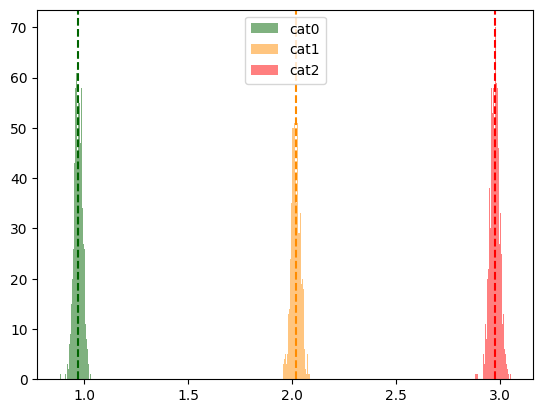

In [23]:
w_x_cat_to_x_con = samples_synthetic['weights_categorical_x_cat_x_con'].squeeze()



cat0 = w_x_cat_to_x_con[:, 0]
cat1 = w_x_cat_to_x_con[:, 1]
cat2 = w_x_cat_to_x_con[:, 2]


plt.hist(cat0, bins=50, alpha=0.5, color="darkgreen", label="cat0")
plt.hist(cat1, bins=50, alpha=0.5, color="darkorange", label="cat1")
plt.hist(cat2, bins=50, alpha=0.5, color="red", label="cat2")
# add colored lines for means
plt.axvline(cat0.mean(), color="darkgreen", linestyle="--")
plt.axvline(cat1.mean(), color="darkorange", linestyle="--")
plt.axvline(cat2.mean(), color="red", linestyle="--")
plt.legend()
plt.show()